<a href="https://colab.research.google.com/github/Paoladidon/python-script/blob/main/%5BSHARED%5D_Screaming_frog_output_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
#install the package that allows to write into an excel file:
!pip install xlsxwriter
import xlsxwriter

import matplotlib.pyplot as plt
import openpyxl

     |████████████████████████████████| 148 kB 5.0 MB/s 


Prompts a file upload from the local drive. Make sure the name of the file is 'internal_all.csv', if not please rename your file:


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving internal_all.csv to internal_all.csv


Imports the csv into a data frame (within Colab). 



In [ ]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['internal_all.csv']))


Prints the file so you can make sure it's uploaded correctly:

In [ ]:
df2.head()

,Address,Content Type,Status Code,Status,Indexability,Indexability Status,Title 1,Title 1 Length,Title 1 Pixel Width,Meta Description 1,Meta Description 1 Length,Meta Description 1 Pixel Width,Meta Keywords 1,Meta Keywords 1 Length,H1-1,H1-1 Length,H1-2,H1-2 Length,H2-1,H2-1 Length,H2-2,H2-2 Length,Meta Robots 1,Meta Robots 2,X-Robots-Tag 1,Meta Refresh 1,Canonical Link Element 1,"rel=""next"" 1","rel=""prev"" 1","HTTP rel=""next"" 1","HTTP rel=""prev"" 1",amphtml Link Element,Size (bytes),Word Count,Text Ratio,Crawl Depth,Link Score,Inlinks,Unique Inlinks,% of Total,Outlinks,Unique Outlinks,External Outlinks,Unique External Outlinks,Closest Similarity Match,No. Near Duplicates,Spelling Errors,Grammar Errors,Hash,Response Time,Last Modified,Redirect URL,Redirect Type,Cookies,HTTP Version,URL Encoded Address,Crawl Timestamp
0,https://www.ayima.com/blog/how-to-keep-your-di...,text/html; charset=UTF-8,301,Moved Permanently,Non-Indexable,Redirected,NaN,0,0,NaN,0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.000,4,NaN,12,12,0.87,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.159,NaN,https://www.ayima.com/uk/insights/how-to-keep-...,HTTP Redirect,NaN,HTTP/1.1,https://www.ayima.com/blog/how-to-keep-your-di...,2021-06-17 15:37:35
1,https://www.ayima.com/ca/contact,text/html; charset=UTF-8,200,OK,Indexable,NaN,Helping Businesses Exceed their Targets | Cont...,55,507,Want to find out how our Search solutions can ...,86,545,NaN,0,We’d love to hear from you,26,NaN,0,Get in touch,12,NaN,0,max-image-preview:large,"max-snippet:-1, max-image-preview:large, max-v...",NaN,NaN,https://www.ayima.com/ca/contact,NaN,NaN,NaN,NaN,NaN,53268,342,4.694,2,NaN,347,340,24.64,24,18,0,0,NaN,NaN,NaN,NaN,8b330d2abb089d4e065e304f40b5b2e3,0.550,NaN,NaN,NaN,NaN,HTTP/1.1,https://www.ayima.com/ca/contact,2021-06-17 15:36:57
2,https://www.ayima.com/uk/author/tamar,text/html; charset=UTF-8,200,OK,Indexable,NaN,Tamar Batrawi - Ayima,21,200,NaN,0,0,NaN,0,Tamar Batrawi,13,NaN,0,NaN,0,NaN,0,max-image-preview:large,"max-snippet:-1, max-image-preview:large, max-v...",NaN,NaN,https://www.ayima.com/uk/author/tamar,NaN,NaN,NaN,NaN,NaN,41050,255,5.085,7,NaN,4,2,0.14,21,17,1,1,NaN,NaN,NaN,NaN,3b33f4257debe02b2d87c585b13165fd,0.507,NaN,NaN,NaN,NaN,HTTP/1.1,https://www.ayima.com/uk/author/tamar,2021-06-17 15:41:42
3,https://www.ayima.com/hk/insights/news/ayima-h...,text/html; charset=UTF-8,200,OK,Indexable,NaN,Ayima In The Press: Helping A Non-Profit Stay ...,63,582,NaN,0,0,NaN,0,Ayima In The Press: Helping A Non-Profit Stay ...,55,NaN,0,More News,9,Is the new Google update good news for high st...,58,max-image-preview:large,"max-snippet:-1, max-image-preview:large, max-v...",NaN,NaN,https://www.ayima.com/hk/insights/news/ayima-h...,NaN,NaN,NaN,NaN,NaN,57997,882,9.706,6,NaN,7,3,0.22,34,24,11,11,NaN,NaN,NaN,NaN,7693c0a1c591a9f8d22f71c7e1ca3684,0.474,NaN,NaN,NaN,NaN,HTTP/1.1,https://www.ayima.com/hk/insights/news/ayima-h...,2021-06-17 15:40:38
4,https://www.ayima.com/us/insights/analytics-an...,text/html; charset=UTF-8,200,OK,Indexable,NaN,20 Useful Google Analytics Segments - Ayima,43,405,NaN,0,0,NaN,0,20 Useful Google Analytics Segments,35,NaN,0,More Analytics & CRO,20,How to Add a List of URLs to a Segment in Adob...,57,max-image-preview:large,"max-snippet:-1, max-image-preview:large, max-v...",NaN,NaN,https://www.ayima.com/us/insights/analytics-an...,NaN,NaN,NaN,NaN,NaN,59654,988,10.688,7,NaN,7,3,0.22,35,23,24,23,NaN,NaN,NaN,NaN,def3824ca12f0c68928d86df07cfeaad,0.444,NaN,NaN,NaN,NaN,HTTP/1.1,https://www.ayima.com/us/insights/analytics-an...,2021-06-17 15:41:41


Visualise how many pages per status code


In [ ]:
#turning the df into a data frame
df_status_code = df2['Status Code'].value_counts().to_frame()

#Resetting the index and renaming columns
df_status_code = df_status_code.reset_index()
df_status_code.columns=['Status code','Number of pages']
df_status_code


,Status code,Number of pages
0,200,1430
1,301,149
2,302,23
3,308,15
4,404,11
5,0,2


In [ ]:

df_status_code_percentage=df2.groupby(["Status Code"])\
.agg({"Address" : "count"})[["Address"]]\
.apply(lambda x: 100*x/x.sum())\
.sort_values(by="Address", ascending=False)
df_status_code_percentage=round(df_status_code_percentage,1)
df_status_code_percentage=pd.DataFrame(df_status_code_percentage)
df_status_code_percentage.reset_index(drop=True,inplace=True)
#adding 5 of total
df_status_code_percentage.rename(columns={'Address':'Percentage of total'})

#concatenating number of pages and % of total
df_status_code.rename(columns={'Status Code':'Page status code'})
df_final=pd.concat([df_status_code,df_status_code_percentage['Address']], axis=1,sort=False)
df_final.rename(columns={'Address':'Percentage of total'},inplace=True)
#df_final

Extracting the list of redirecting pages:

In [ ]:

df_redirecting_pages=df2[(df2['Status Code']>200) & (df2['Status Code']<400)]

df_r_pages=df_redirecting_pages[['Address','Status Code','Inlinks','Unique Inlinks','Redirect URL']]

df_r_pages.reset_index(drop=True,inplace=True)

#df_r_pages.head()

Extracting the list of broken pages:

In [ ]:
df_broken_pages=df2[df2['Status Code']>399]
df_b_pages=df_broken_pages[['Address','Status Code','Inlinks','Unique Inlinks']]
df_b_pages.reset_index(drop=True,inplace=True)

#df_b_pages.head()

Extracting the list of unresponsive pages

In [ ]:
df_noresponse_pages=df2[df2['Status Code']>500]
df_nr_pages=df_noresponse_pages[['Address','Status Code','Inlinks','Unique Inlinks']]
df_nr_pages.reset_index(drop=True,inplace=True)
#df_nr_pages.head()

Finding how many pages have a 200 status code and are not indexable

In [ ]:
dfok=df2[df2['Status Code']==200]
dfok_not_indexable=dfok[dfok.stack().str.contains('Non-Indexable').any(level=0)]
number_of_pages=len(dfok_not_indexable)
dfok_not_ind=dfok_not_indexable[['Address','Indexability','Indexability Status','Meta Robots 1']]

df_not_indexable_stats=pd.DataFrame(['The number of non indexable pages is',number_of_pages])
df_not_indexable_stats.columns=['Indexability stats']
pd.options.display.max_columns = 80

#calculating it as % of total
number_of_rows=len(dfok_not_indexable)

full_fd_length=len(df2)

percent_of_tot=(number_of_rows/full_fd_length)*100
percent_of_tot=round(percent_of_tot,1)
df_percent_of_tot=pd.DataFrame(['Percentage of total',percent_of_tot])
df_percent_of_tot.reset_index(drop=True,inplace=True)
list(df_percent_of_tot.columns)
df_percent_of_tot.rename(columns={0:'Percentage'},inplace=True)

#concatenating the results
df_final_indexability=pd.concat([df_not_indexable_stats,df_percent_of_tot], axis=1,sort=False)
df_final_indexability




,Indexability stats,Percentage
0,The number of non indexable pages is,Percentage of total
1,149,9.1


Finding how many pages are 200 status code and have parameters

In [ ]:

df_parameters= dfok.loc[dfok['Address'].str.contains("=",)]
number_of_param_pages=len(df_parameters)

df_param_final=df_parameters[['Address','Status Code','Indexability','Indexability Status','Meta Robots 1','Canonical Link Element 1','Inlinks','Unique Inlinks']]

df_stats_parameter=pd.DataFrame(['The number of pages with parameters is',number_of_param_pages])
df_stats_parameter.columns=['Parameterised Pages']
#df_stats_parameter

#calculating it as % of total
percent_of_tot=(number_of_param_pages/full_fd_length)*100
percent_of_tot=round(percent_of_tot,1)

df_percent_of_tot=pd.DataFrame(['Percentage of total',percent_of_tot])
df_percent_of_tot.reset_index(drop=True,inplace=True)
list(df_percent_of_tot.columns)
df_percent_of_tot.rename(columns={0:'Percentage'},inplace=True)

df_final_parameterised=pd.concat([df_stats_parameter,df_percent_of_tot], axis=1,sort=False)
df_final_parameterised

,Parameterised Pages,Percentage
0,The number of pages with parameters is,Percentage of total
1,180,11


Finding how many pages have a title that is too short or too long:

In [ ]:
dfok_indexable = dfok[dfok['Indexability']=='Indexable']

df_short_title= dfok_indexable[(dfok_indexable['Title 1 Length'] <= 30) ]
df_s_title=df_short_title[['Address','Indexability','Title 1', 'Title 1 Length','Meta Description 1','H1-1']]

df_long_title= dfok_indexable[(dfok_indexable['Title 1 Length'] > 60) ]
df_l_title=df_long_title[['Address','Indexability','Title 1', 'Title 1 Length','Meta Description 1','H1-1']]

df_s_title.reset_index(drop=True,inplace=True)
df_l_title.reset_index(drop=True,inplace=True)


Extracting the list of pages missing title tags

In [ ]:
df_missing_title=dfok_indexable[(dfok_indexable['Title 1 Length']==0)]
df_m_title=df_missing_title[['Address','Indexability','Title 1', 'Title 1 Length','Meta Description 1','H1-1']]
#df_m_title.head()

#counting number of pages missing the title
missing_title=len(df_m_title)
df_stats_m_titles=pd.DataFrame(['The number of pages missing a title tag is',missing_title])
df_stats_m_titles.columns=['Pages missing titles']
df_stats_m_titles

,Pages missing titles
0,The number of pages missing a title tag is
1,50


Extracting the list of pages missing a meta description

In [ ]:
df_missing_desc=dfok_indexable[(dfok_indexable['Meta Description 1 Length']==0)]
df_m_desc=df_missing_desc[['Address','Indexability','Title 1', 'Title 1 Length','Meta Description 1','H1-1']]
#df_m_desc.head()

#counting he number of oages missing description
missing_desc=len(df_m_desc)
df_stats_m_desc=pd.DataFrame(['The number of pages missing a meta description is',missing_desc])
df_stats_m_desc.columns=['Pages missing description']
df_stats_m_desc

,Pages missing description
0,The number of pages missing a meta description is
1,1006


In [ ]:
short_title_number_pages=len(df_short_title)
df_stats_short_title=pd.DataFrame(['The number of indexable pages with short titles is',short_title_number_pages])
df_stats_short_title.columns=['Pages with short titles']
df_stats_short_title


,Pages with short titles
0,The number of indexable pages with short title...
1,280


In [ ]:
long_title_number_pages=len(df_long_title)
df_stats_long_title=pd.DataFrame(['The number of indexable pages with long titles is',long_title_number_pages])
df_stats_long_title.columns=['Pages with long titles']
df_stats_long_title

,Pages with long titles
0,The number of indexable pages with long titles is
1,267


Visualise how many pages have the same title:

In [ ]:
df_title_repetition = df2['Title 1'].value_counts().to_frame()
df_title_repetition = df_title_repetition.reset_index()
df_title_repetition.columns =['Title 1','pages']
#df_title_repetition

Putting together outputs in an excel file:

In [ ]:
with pd.ExcelWriter('output.xlsx', engine='xlsxwriter') as writer:
   
    df_final.to_excel(writer, sheet_name='Stats', index=False)
    
    df_final_indexability.to_excel(writer, sheet_name='Stats', index=False,
                      startrow=(df_status_code.shape[0] + 2))
    
    for column in df_final_indexability:
      column_width = max(df_final_indexability[column].astype(str).map(len).max(), len(column))
      col_idx = df_final_indexability.columns.get_loc(column)
    writer.sheets['Stats'].set_column(col_idx, col_idx, column_width)
   
    df_final_parameterised.to_excel(writer, sheet_name='Stats', index=False,
                      startrow=(df_status_code.shape[0] +6))
   
    df_stats_short_title.to_excel(writer,sheet_name='Stats', index=False,
                       startrow=(df_status_code.shape[0] +10))
   
    df_stats_long_title.to_excel(writer,sheet_name='Stats', index=False,
                       startrow=(df_status_code.shape[0] +14))  
    
    df_stats_m_titles.to_excel(writer,sheet_name='Stats', index=False,
                       startrow=(df_status_code.shape[0] +18)) 
    
    df_stats_m_desc.to_excel(writer,sheet_name='Stats', index=False,
                       startrow=(df_status_code.shape[0] +22))
    

#write data in a different tab:

    df_r_pages.to_excel(writer,sheet_name='Redirecting pages', index=False)
    for column in df_r_pages:
      col_idx = df_r_pages.columns.get_loc(column)
    writer.sheets['Redirecting pages'].set_column(col_idx, col_idx, 30)

    df_b_pages.to_excel(writer,sheet_name='Broken pages', index=False)
    for column in df_b_pages:
       col_idx = df_b_pages.columns.get_loc(column)
    writer.sheets['Broken pages'].set_column(col_idx, col_idx, 30)

    df_nr_pages.to_excel(writer,sheet_name='5xx pages',index=False)  
    for column in df_nr_pages:
       col_idx = df_nr_pages.columns.get_loc(column)
    writer.sheets['5xx pages'].set_column(col_idx, col_idx, 30)


    dfok_not_ind.to_excel(writer,sheet_name='Not_indexable', index=False )
    for column in dfok_not_ind:
     col_idx = dfok_not_ind.columns.get_loc(column)
    writer.sheets['Not_indexable'].set_column(col_idx, col_idx, 40)

#col_idx = df.columns.get_loc('this_is_a_long_column_name')
#writer.sheets['my_analysis'].set_column(col_idx, col_idx, 30)

    df_param_final.to_excel(writer, sheet_name='Parameterised_URLs', index=False)
    for column in df_param_final:
      col_idx = df_param_final.columns.get_loc(column)
    writer.sheets['Parameterised_URLs'].set_column(col_idx, col_idx, 40)

    df_s_title.to_excel(writer,sheet_name='Short titles',index=False)
    for column in df_s_title:
        col_idx = df_s_title.columns.get_loc(column)
    writer.sheets['Short titles'].set_column(col_idx, col_idx, 40)

    df_l_title.to_excel(writer,sheet_name='Long titles',index=False)
    for column in df_l_title:
     # column_width = df_l_title[column].astype(str).str.len().max()
     # column_width = max(column_width, len(column))
      col_idx = df_l_title.columns.get_loc(column)
    writer.sheets['Long titles'].set_column(col_idx, col_idx, 40)

    df_m_title.to_excel(writer,sheet_name='Missing titles',index=False)
    for column in df_m_title:
     # column_width = df_l_title[column].astype(str).str.len().max()
     # column_width = max(column_width, len(column))
      col_idx = df_m_title.columns.get_loc(column)
    writer.sheets['Missing titles'].set_column(col_idx, col_idx, 40)

    df_m_desc.to_excel(writer,sheet_name='Missing description',index=False)
    for column in df_m_desc:
      col_idx = df_m_desc.columns.get_loc(column)
    writer.sheets['Missing description'].set_column(col_idx, col_idx, 40)

    df_title_repetition.to_excel(writer,sheet_name='Duplicate_titles', index=False)
    for column in df_title_repetition:
      col_idx = df_title_repetition.columns.get_loc(column)
    writer.sheets['Duplicate_titles'].set_column(col_idx, col_idx, 40)
   


from google.colab import files
files.download('output.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualise on a graph: 

*   Page status code
*   Title length
*   Meta description length





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb334653890>]],
      dtype=object)

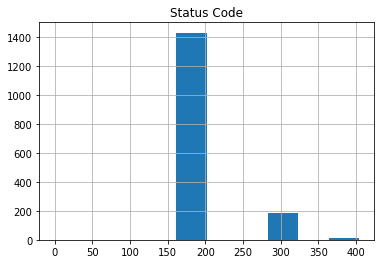

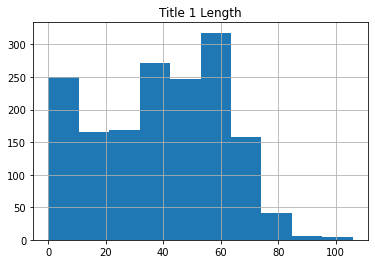

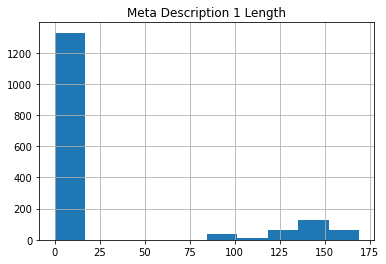

In [ ]:
df2.hist('Status Code')
df2.hist('Title 1 Length')
df2.hist('Meta Description 1 Length')
